In [1]:
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.arlstem import ARLSTem
from nltk.classify import SklearnClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.contrib import learn
from CNN import *

In [2]:
print("reading the dataset.....")
data = pd.read_csv('../data/datasets/combined_dataset.csv', encoding = "utf-8")
data = data[['class','tweet']]
data = data.reindex(np.random.permutation(data.index))
data = data[1:2000]

print("cleaning the dataset....")
data['cleaned_tweet'] = data['tweet'].map(lambda v: clean_sentence(v)[0])
data['cleaned_tweet_text_only'] = data['tweet'].map(lambda v: clean_sentence(v)[1])

print("building features....")
all_document = data['cleaned_tweet']
tfidf_vectorizer = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=word_tokenize)
tfidf_model = tfidf_vectorizer.fit(all_document)

data['handed_features'] = data['cleaned_tweet'].map(lambda v: featurize(v, tfidf_model))
pos_neg_data = data[data['class'] != 'neutral']
pos_neg_data['label_encoded'] = pos_neg_data['class'].map(encode_class_labels)
print("finish processing...")

reading the dataset.....
cleaning the dataset....
building features....
finish processing...


C:\Users\Mokhtar Ahmed\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


class SLP_Classifer(object):
      def __init__(self,input_size,num_classes) :
            
        self.input_x = tf.placeholder(tf.float32, [None, input_size], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        

        W = tf.get_variable("W", shape=[input_size, 2], initializer=tf.contrib.layers.xavier_initializer(),)
        b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")

        #l2_loss += tf.nn.l2_loss(W)
        #l2_loss += tf.nn.l2_loss(b)

        tscores = tf.nn.xw_plus_b(self.input_x, W, b, name="scores")
        self.scores = tf.nn.relu(tscores)
        self.predictions = tf.argmax(self.scores, 1, name="predictions")

        losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
        self.loss = tf.reduce_mean(losses) #+ l2_reg_lambda * l2_loss
        
        #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.input_y,logits=self.scores)
        #self.loss = tf.reduce_mean(loss, axis=1)
        
        self.expected = tf.argmax(self.input_y, 1)
        self.correct_predictions = tf.equal(self.predictions, self.expected)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, "float"), name="accuracy")

In [3]:
class SLP_Classifer(object):
      def __init__(self,input_size,num_classes) :
            
        self.input_x = tf.placeholder(tf.float32, [None, input_size], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        
        layer_size = int(0.6 * input_size)
        print("layer1 size = ", layer_size)
        self.leyer1 = tf.contrib.layers.fully_connected(self.input_x, layer_size, activation_fn=tf.nn.relu)
        
        layer_size = int(0.6 * input_size)
        print("layer2 size = ", layer_size)
        self.leyer2 = tf.contrib.layers.fully_connected(self.leyer1, layer_size, activation_fn=tf.nn.relu)
        
        layer_size = int(0.5* input_size)
        print("layer3 size = ", layer_size)
        self.leyer3 = tf.contrib.layers.fully_connected(self.leyer2, layer_size, activation_fn=tf.nn.relu)
        
        self.scores = tf.contrib.layers.fully_connected(self.leyer3, num_classes, activation_fn=tf.nn.sigmoid)
        self.predictions = tf.argmax(self.scores, 1, name="predictions")

        losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
        self.loss = tf.reduce_mean(losses) #+ l2_reg_lambda * l2_loss

        self.expected = tf.argmax(self.input_y, 1)
        self.correct_predictions = tf.equal(self.predictions, self.expected)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, "float"), name="accuracy")

In [4]:
num_classes = 2
features_size = len(list(pos_neg_data.iloc[0]['handed_features']))
l2_reg_lambda = 0.1
see("features_size", features_size)
classifer = SLP_Classifer(features_size, num_classes)



====================== features_size==========================
9762
layer1 size =  5857
layer2 size =  5857
layer3 size =  4881


In [5]:
learning_rate = 0.05
#tf.train.AdagradOptimizer(learning_rate).minimize(classifer.loss)
tf.train.GradientDescentOptimizer(learning_rate).minimize(classifer.loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [6]:
train, test = train_test_split(pos_neg_data, test_size=0.1)
print("training set size = " + str(len(train)))
print("testing set size = " + str(len(test)))

training set size = 1216
testing set size = 136


In [7]:
def generate_batch_data(train_data, batch_size=10):
    batch_data = train.sample(n=batch_size, replace=False)
    #see("batch_size = ",  len(list(batch_data["handed_features"])[0]))
    x_train_features = np.array(list(batch_data["handed_features"]))
    y_train = np.array(list(batch_data["label_encoded"]))
    #print(y_train)
    #print(x_train_features.shape)
    #print(y_train.shape)
    return x_train_features, y_train


def train_step(batch_id, x_feat, y_batch):
    feed_dict = {classifer.input_x: x_feat, classifer.input_y: y_batch}
    loss, accuracy = sess.run([classifer.loss, classifer.accuracy], feed_dict)
    scores, predictions, expected = sess.run([classifer.scores, classifer.predictions, classifer.expected], feed_dict)
    #print(scores)
    #print(predictions)
    #print(expected)
    #print(loss, ' --- ', accuracy)
    print("bacht_no {:g}, loss {:g}, acc {:g}".format(batch_id, loss, accuracy))
    return loss, accuracy


def dev_step(x_batch, y_batch):
    return train_step(1, x_feat,y_batch)

In [ ]:
iterations = 1000
batch_size = len(test)
evaluate_every = 100

train_loss = []
train_acc = []
test_loss = []
test_acc = []
i_data = []
ii_data = range(iterations)

for batch_id in ii_data:
    train_shuffled = train.reindex(np.random.permutation(train.index))
    x_feat, y_batch = generate_batch_data(train_shuffled, batch_size)
    loss, accuracy = train_step(batch_id, x_feat, y_batch)
    train_loss.append(loss)
    train_acc.append(accuracy)
    
    if (batch_id % evaluate_every == 0):
        print("\n------------- Evaluation -------------------")
        test_shuffled = test.reindex(np.random.permutation(test.index))
        x_dev, y_dev = generate_batch_data(test_shuffled, test.shape[0])
        loss, accuracy = dev_step(x_dev, y_dev)
        test_loss.append(loss)
        test_acc.append(accuracy)
        i_data.append(batch_id + 1)
        print("----------------------------------------------")
 
    

bacht_no 0, loss 0.693274, acc 0.463235

------------- Evaluation -------------------
bacht_no 1, loss 0.693171, acc 0.522059
----------------------------------------------
bacht_no 1, loss 0.693004, acc 0.544118
bacht_no 2, loss 0.693105, acc 0.522059
bacht_no 3, loss 0.693271, acc 0.441176
bacht_no 4, loss 0.693138, acc 0.507353
bacht_no 5, loss 0.693065, acc 0.573529
bacht_no 6, loss 0.693181, acc 0.492647
bacht_no 7, loss 0.693352, acc 0.426471
bacht_no 8, loss 0.69323, acc 0.485294
bacht_no 9, loss 0.693332, acc 0.485294
bacht_no 10, loss 0.693263, acc 0.455882
bacht_no 11, loss 0.693272, acc 0.507353
bacht_no 12, loss 0.693101, acc 0.514706
bacht_no 13, loss 0.693058, acc 0.558824
bacht_no 14, loss 0.693049, acc 0.514706
bacht_no 15, loss 0.693164, acc 0.485294
bacht_no 16, loss 0.693246, acc 0.470588
bacht_no 17, loss 0.693207, acc 0.507353
bacht_no 18, loss 0.693314, acc 0.477941
bacht_no 19, loss 0.693225, acc 0.5
bacht_no 20, loss 0.693204, acc 0.507353
bacht_no 21, loss 0.69

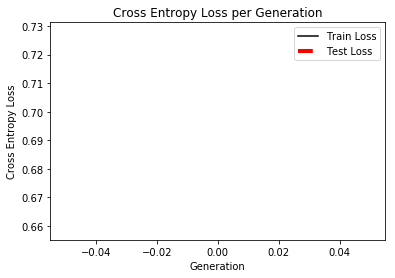

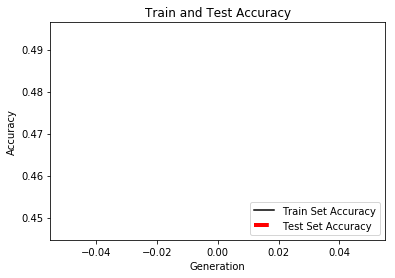

In [9]:

# Plot loss over time
plt.plot(ii_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(ii_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()